In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import math
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv

In [3]:
class SiVObject():
    def __init__(self, B=[0,0,0], alpha_g=0, beta_g=0, alpha_e=0, beta_e=0, f=0.1, lambda_g=45, lambda_e=257, ups_gx=11, ups_gy=11, ups_ex=20, ups_ey=20, Delta_eg=4.159e5):
        
        # magnetic field
        self.B = B
        
        # stress response components
        self.alpha_g = alpha_g
        self.beta_g = beta_g
        self.alpha_e = alpha_e
        self.beta_e = beta_e
        
        # spin-orbit coupling factors
        self.f = f
        self.lambda_g = lambda_g
        self.lambda_e = lambda_e
        
        # Jan-Teller effect constants
        self.ups_gx = ups_gx
        self.ups_gy = ups_gy
        self.ups_ex = ups_ex
        self.ups_ey = ups_ey
        
        # excited-ground state splitting
        self.Delta_eg = Delta_eg
        
        self.Hfull = self.build_SiV_Hamiltonian()
        
        H_sep = self.build_SiV_Hamiltonian_sep()
        self.Hg = H_sep[0]
        self.He = H_sep[1]
        
    # this function builds the complete SiV Hamiltonian (both the excited and ground states)
    # in the orbital eigenstates basis described by Christian Hepp in his thesis (2014)
    
    def build_SiV_Hamiltonian(self):
        
        B=self.B
        alpha_g=self.alpha_g
        beta_g=self.beta_g
        alpha_e=self.alpha_e
        beta_e=self.beta_e
        f=self.f
        lambda_g=self.lambda_g
        lambda_e=self.lambda_e 
        ups_gx=self.ups_gx
        ups_gy=self.ups_gy
        ups_ex=self.ups_ex
        ups_ey=self.ups_ey 
        Delta_eg=self.Delta_eg

        Bx = B[0]
        By = B[1]
        Bz = B[2]

        # orbital and electron gyromagnetic ratios in GHz/T
        gamma_l = 14.1 
        gamma_s = 28.2 

        # unperturbed orbital basis states
        egxu = basis(8,0)
        egxd = basis(8,1)
        egyu = basis(8,2)
        egyd = basis(8,3)
        euxu = basis(8,4)
        euxd = basis(8,5)
        euyu = basis(8,6)
        euyd = basis(8,7)

        # Unperturbed Hamiltonian
        H0 = Delta_eg * (ket2dm(euxu) + ket2dm(euxd) + ket2dm(euyu) + ket2dm(euyd))

        # Spin-Orbit coupling
        HSO = lambda_g / 2 * (-1j*egyu*egxu.dag() + 1j*egxu*egyu.dag() + 1j*egyd*egxd.dag() - 1j*egxd*egyd.dag()) \
            + lambda_e / 2 * (-1j*euyu*euxu.dag() + 1j*euxu*euyu.dag() + 1j*euyd*euxd.dag() - 1j*euxd*euyd.dag())

        # Jan-Teller effect
        HJT = ups_gx * (ket2dm(egxu) + ket2dm(egxd) - ket2dm(egyu) - ket2dm(egyd)) \
            + ups_gy * (egyu*egxu.dag() + egxu*egyu.dag() + egyd*egxd.dag() + egxd*egyd.dag()) \
            + ups_ex * (ket2dm(euxu) + ket2dm(euxd) - ket2dm(euyu) - ket2dm(euyd)) \
            + ups_ey * (euyu*euxu.dag() + euxu*euyu.dag() + euyd*euxd.dag() + euxd*euyd.dag())

        # Zeeman effect - spin
        HZS = gamma_s*(Bz*(ket2dm(egxu) - ket2dm(egxd) + ket2dm(egyu) - ket2dm(egyd) \
                          + ket2dm(euxu) - ket2dm(euxd) + ket2dm(euyu) - ket2dm(euyd)) \
                    + (Bx-1j*By)*1j*egxd*egxu.dag() + (Bx+1j*By)*egxu*egxd.dag() + (Bx-1j*By)*1j*egyd*egyu.dag() + (Bx+1j*By)*egyu*egyd.dag() \
                    + (Bx-1j*By)*1j*euxd*euxu.dag() + (Bx+1j*By)*euxu*euxd.dag() + (Bx-1j*By)*1j*euyd*euyu.dag() + (Bx+1j*By)*euyu*euyd.dag())    

        # Zeeman effect - orbital
        HZL = f*gamma_l*Bz*(1j*egyu*egxu.dag() - 1j*egxu*egyu.dag() + 1j*egyd*egxd.dag() - 1j*egxd*egyd.dag() \
                        + 1j*euyu*euxu.dag() - 1j*euxu*euyu.dag() + 1j*euyd*euxd.dag() - 1j*euxd*euyd.dag())
        
        # Strain 
        HStrain = beta_g*(egyu*egxu.dag() + egxu*egyu.dag() + egyd*egxd.dag() + egxd*egyd.dag()) \
            + beta_e*(euyu*euxu.dag() + euxu*euyu.dag() + euyd*euxd.dag() + euxd*euyd.dag()) \
            + alpha_g*(ket2dm(egxu) + ket2dm(egxd) - ket2dm(egyu) - ket2dm(egyd)) \
            + alpha_e*(ket2dm(euxu) + ket2dm(euxd) - ket2dm(euyu) - ket2dm(euyd))

        return H0 + HSO + HJT + HZS + HZL + HStrain
    
    # this function builds two SiV Hamiltonians, one for the ground states (Hg) 
    # and one for the excited states (He), separately in the orbital eigenstates
    # basis described by Christian Hepp in his thesis (2014)
    
    def build_SiV_Hamiltonian_sep(self):

        B=self.B
        alpha_g=self.alpha_g
        beta_g=self.beta_g
        alpha_e=self.alpha_e
        beta_e=self.beta_e
        f=self.f
        lambda_g=self.lambda_g
        lambda_e=self.lambda_e 
        ups_gx=self.ups_gx
        ups_gy=self.ups_gy
        ups_ex=self.ups_ex
        ups_ey=self.ups_ey 
        Delta_eg=self.Delta_eg
        
        Bx = B[0]
        By = B[1]
        Bz = B[2]

        # orbital and electron gyromagnetic ratios in GHz/T
        gamma_l = 14.1 #88
        gamma_s = 28.2 #176

        # unperturbed orbital basis states
        exu = basis(4,0)
        exd = basis(4,1)
        eyu = basis(4,2)
        eyd = basis(4,3)

        # Spin-Orbit coupling
        HSO_g = lambda_g / 2 * (-1j*eyu*exu.dag() + 1j*exu*eyu.dag() + 1j*eyd*exd.dag() - 1j*exd*eyd.dag())
        HSO_e = lambda_e / 2 * (-1j*eyu*exu.dag() + 1j*exu*eyu.dag() + 1j*eyd*exd.dag() - 1j*exd*eyd.dag())


        # Jan-Teller effect
        HJT_g = ups_gx * (ket2dm(exu) + ket2dm(exd) - ket2dm(eyu) - ket2dm(eyd)) \
            + ups_gy * (eyu*exu.dag() + exu*eyu.dag() + eyd*exd.dag() + exd*eyd.dag())
        HJT_e = ups_ex * (ket2dm(exu) + ket2dm(exd) - ket2dm(eyu) - ket2dm(eyd)) \
            + ups_ey * (eyu*exu.dag() + exu*eyu.dag() + eyd*exd.dag() + exd*eyd.dag())

        # Zeeman effect - spin
        HZS = gamma_s*(Bz*(ket2dm(exu) - ket2dm(exd) + ket2dm(eyu) - ket2dm(eyd)) \
                    + (Bx-1j*By)*1j*exd*exu.dag() + (Bx+1j*By)*exu*exd.dag() + (Bx-1j*By)*1j*eyd*eyu.dag() + (Bx+1j*By)*eyu*eyd.dag())   

        # Zeeman effect - orbital
        HZL = f*gamma_l*Bz*(1j*eyu*exu.dag() - 1j*exu*eyu.dag() + 1j*eyd*exd.dag() - 1j*exd*eyd.dag())
        
        # Strain 
        HStrain_g = beta_g*(eyu*exu.dag() + exu*eyu.dag() + eyd*exd.dag() + exd*eyd.dag()) \
            + alpha_g*(ket2dm(exu) + ket2dm(exd) - ket2dm(eyu) - ket2dm(eyd))
        HStrain_e = beta_e*(eyu*exu.dag() + exu*eyu.dag() + eyd*exd.dag() + exd*eyd.dag()) \
            + alpha_e*(ket2dm(exu) + ket2dm(exd) - ket2dm(eyu) - ket2dm(eyd))

        return [HSO_g + HJT_g + HZS + HZL + HStrain_g, HSO_e + HJT_e + HZS + HZL + HStrain_e]
    
    
    # this function updates all values in the full, ground, and excited Hamiltonians
    # you specify. If no arguments are given to the function (e.g. siv.update_val() is called),
    # nothing changes
    
    def update_val(self, B=[], alpha_g=None, beta_g=None, alpha_e=None, beta_e=None, f=None, lambda_g=None, lambda_e=None, ups_gx=None, ups_gy=None, ups_ex=None, ups_ey=None, Delta_eg=None):
        if len(B):
            self.B = B
        if alpha_g is not None:
            self.alpha_g = alpha_g
        if beta_g is not None:
            self.beta_g = beta_g
        if alpha_e is not None:
            self.alpha_e = alpha_e
        if beta_e is not None:
            self.beta_e = beta_e
        if f is not None:
            self.f = f
        if lambda_g is not None:
            self.lambda_g = lambda_g
        if lambda_e is not None:
            self.lambda_e = lambda_e
        if ups_gx is not None:
            self.ups_gx = ups_gx
        if ups_gy is not None:
            self.ups_gy = ups_gy
        if ups_ex is not None:
            self.ups_ex = ups_ex
        if ups_ey is not None:
            self.ups_ey = ups_ey
        if Delta_eg is not None:
            self.Delta_eg = Delta_eg
            
        self.Hfull = self.build_SiV_Hamiltonian()
        
        H_sep = self.build_SiV_Hamiltonian_sep()
        self.Hg = H_sep[0]
        self.He = H_sep[1]
        
    
    # This function sweeps through all magnetic field values given by B and 
    # returns the eigenenergies and eigenvectors. B is an array
    # with shape (3, N_B), where N_B is the number of magnetic fields to be
    # swept. If plot is True, the eigenenergies will be plotted in function
    # of the magnitude of B (only makes sense if B is linearly increasing in 
    # one direction)
        
    def sweep_B_field_eigenenergies(self, B, plot=True):
        bands = np.zeros([2,len(B[0,:]),4])
        states = [[], []]
        B_mag = np.zeros(len(B[0,:]))

        for ii in range(len(B[0,:])):
            self.update_val(B=B[:,ii])
            bands[0,ii,:] = (self.Hg.eigenenergies()).real
            bands[1,ii,:] = (self.He.eigenenergies()).real
            states[0].append(self.Hg.eigenstates())
            states[1].append(self.He.eigenstates())
            B_mag[ii] = np.sqrt(B[0,ii]**2 + B[1,ii]**2 + B[2,ii]**2)

        if plot:
            fig, axes = plt.subplots(2, 1, figsize=(8, 6))
            for jj in range(4):
                axes[1].plot(B_mag, bands[0,:,jj],'b')
                axes[0].plot(B_mag, bands[1,:,jj],'r')

            axes[1].set_xlabel('Magnetic field strength [T]')
            axes[1].set_ylabel('Ground eigenenergies [GHz]')
            axes[0].set_ylabel('Excited eigenenergies [GHz]')
            fig.show()
            
        return [bands, states]
    
    # This function sweeps through all magnetic field values given by B and 
    # returns the transition frequencies of transitions between the ground
    # and excited states. B is an array with shape (3, N_B), where N_B is
    # the number of magnetic fields to be swept. If plot is True, the transition
    # frequencies will be plotted in function of the magnitude of B (only 
    # makes sense if B is linearly increasing in one direction). If frozen
    # is set to False, all transitions between ground and excited states are 
    # possible. If frozen is set to True, only the transitions between the two
    # lowest excited states and two lowest ground states will be considered
    
    def sweep_B_field_transitions(self, B, frozen=False, plot=True):
        B_mag = np.zeros(len(B[0,:]))
        
        if frozen:
            transitions = np.zeros([4, len(B[0,:])])
            for ii in range(len(B[0,:])):
                self.update_val(B=B[:,ii])
                bands_g = (self.Hg.eigenenergies()).real
                bands_e = (self.He.eigenenergies()).real
                B_mag[ii] = np.sqrt(B[0,ii]**2 + B[1,ii]**2 + B[2,ii]**2)
                for jj in range(2):
                    for kk in range(2):
                        transitions[2*jj+kk,ii] = bands_e[jj] - bands_g[kk] + 0*self.Delta_eg

            if plot:
                fig, axes = plt.subplots(1, 1, figsize=(8, 6))
                for ii in range(4):
                    axes.plot(B_mag, transitions[ii,:],'k', linewidth=2)

                axes.set_xlabel('Magnetic field strength [T]')
                axes.set_ylabel('Transition frequency [GHz]')
                fig.show()
            
        else:
            transitions = np.zeros([16, len(B[0,:])])
            for ii in range(len(B[0,:])):
                self.update_val(B=B[:,ii])
                bands_g = (self.Hg.eigenenergies()).real
                bands_e = (self.He.eigenenergies()).real
                B_mag[ii] = np.sqrt(B[0,ii]**2 + B[1,ii]**2 + B[2,ii]**2)
                for jj in range(4):
                    for kk in range(4):
                        transitions[4*jj+kk,ii] = bands_e[jj] - bands_g[kk] + 0*self.Delta_eg

            if plot:
                fig, axes = plt.subplots(1, 1, figsize=(8, 6))
                for ii in range(16):
                    axes.plot(B_mag, transitions[ii,:],'k', linewidth=2)

                axes.set_xlabel('Magnetic field strength [T]')
                axes.set_ylabel('Transition frequency [GHz]')
                fig.show()
            
        return transitions
    
    # This function will show a graphical representation of the eigenstates of the
    # ground states Hamiltonian if mode='ground' or excited states Hamiltonian if
    # mode='excited'. There are two visualization options: 'circles' and 'dm'.
    
    def show_eigenstates(self, mode='ground', visualization='circles'):

        if mode == 'ground':
            states = self.Hg.eigenstates()
        
        if mode == 'excited':
            states = self.He.eigenstates()
        
        
        glabels = ['$\left | e_{gx} \\uparrow \\right \\rangle$', \
                  '$\left | e_{gx} \\downarrow \\right \\rangle$', \
                  '$\left | e_{gy} \\uparrow \\right \\rangle$', \
                  '$\left | e_{gy} \\downarrow \\right \\rangle$', \
                  ]
        elabels = ['$\left | e_{ux} \\uparrow \\right \\rangle$', \
                  '$\left | e_{ux} \\downarrow \\right \\rangle$', \
                  '$\left | e_{uy} \\uparrow \\right \\rangle$', \
                  '$\left | e_{uy} \\downarrow \\right \\rangle$', \
                  ]
        
        if visualization == 'circles':
            fig, axes = plt.subplots(1, 4, figsize=(20,4))
            for ii in range(4):
                for jj in range(4):
                    axes[ii].plot(jj+1,np.angle(states[1][ii][jj]), "ro", markersize=50*abs(states[1][ii][jj])**2)

                axes[ii].plot([0,5],[0,0],'k--')
                axes[ii].plot([0,5],[-np.pi/2,-np.pi/2],'k--')
                axes[ii].plot([0,5],[np.pi/2,np.pi/2],'k--')
                axes[ii].set_xlim([0,5])
                axes[ii].set_ylim([-np.pi,np.pi])
                axes[ii].set_xticks([1, 2, 3, 4])
                axes[ii].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])

                if mode == 'ground':
                    axes[ii].set_xticklabels(glabels, fontsize=15, rotation=45);
                if mode == 'excited':
                    axes[ii].set_xticklabels(elabels, fontsize=15, rotation=45);


                axes[ii].set_yticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'], fontsize=15);
            fig.show()
                
        if visualization == 'dm':
            fig = plt.figure()
            fig.set_size_inches(20, 5.5, forward=True)
            for ii in range(4):
                axe = fig.add_subplot(1,4,ii+1, projection='3d')
                if mode == 'ground':
                    matrix_histogram_complex(states[1][ii]*states[1][ii].dag(), colorbar=np.floor((ii+1)/4), xlabels=glabels, ylabels=glabels, limits=[-1,1], ax=axe)
                if mode == 'excited':
                    matrix_histogram_complex(states[1][ii]*states[1][ii].dag(), colorbar=np.floor((ii+1)/4), xlabels=elabels, ylabels=elabels, limits=[-1,1], ax=axe)
            fig.show()

            
    def qubit_splitting_Bmag(self, orientation = [1,1,1]):
        Magnitude = np.linspace(0,1,40)
        
        B = np.zeros([3,40])
        B[0,:] = np.linspace(0,1,40) * orientation[0] / np.linalg.norm(orientation)
        B[1,:] = np.linspace(0,1,40) * orientation[1] / np.linalg.norm(orientation)
        B[2,:] = np.linspace(0,1,40) * orientation[2] / np.linalg.norm(orientation)
        
        splitting = np.zeros(40)
        for ii in range(40):
            self.update_val(B=B[:,ii])
            bands = (self.Hg.eigenenergies()).real
            splitting[ii] = bands[1] - bands[0]

        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        
        axes.plot(Magnitude, splitting, linewidth=2)
        axes.set_xlabel('Magnetic field strength [T]', fontsize=15)
        axes.set_ylabel('splitting [GHz]', fontsize=15)
        fig.show()
        
    def qubit_splitting_sphere(self, B_mag):    
        Magnitude = B_mag

        xx, yy, zz = np.meshgrid(np.radians(np.arange(0, 369, 9, )), 
                                 np.radians(np.arange(-90, 94.5, 4.5)), 
                                 [0])
        
        splitting = np.zeros([40,40])
        for ii in range(40):
            for jj in range(40):
                b = Magnitude*np.array([np.cos(yy[ii,jj,0])*np.cos(xx[ii,jj,0]), np.cos(yy[ii,jj,0])*np.sin(xx[ii,jj,0]), np.sin(yy[ii,jj,0])])
                self.update_val(B=b)
                bands = (self.Hg.eigenenergies()).real
                splitting[ii,jj] = bands[1] - bands[0]

        # Transform to spherical coordinates
        radius = 6371.0e6
        x = radius * np.cos(yy) * np.cos(xx)
        y = radius * np.cos(yy) * np.sin(xx)
        z = radius * np.sin(yy)

        grid = pv.StructuredGrid(x, y, z)
        grid.cell_arrays['lsm'] = splitting.ravel(order='F')

        grid.plot(cmap=plt.cm.jet, clim=[0, np.max(splitting)], stitle='Qubit splitting [GHz] for |B| = {}T'.format(B_mag))
        
    
    # This function sweeps through all magnetic field values given by B and 
    # returns the dipole transition rates between the two lowest excited states
    # and two lowest ground states. E is the emitted photon electric field. 
    # B is an array with shape (3, N_B), where N_B is
    # the number of magnetic fields to be swept. If plot is True, the 
    # transition rates as well as the spin-nonconserving/spin-conserving transition
    # ratios will be plotted in function of the magnitude of B (only 
    # makes sense if B is linearly increasing in one direction)
    
    def dipole_transitions(self, B, E=[1,1,1], plot=True):
        
        # unperturbed orbital basis states
        egxu = basis(8,0)
        egxd = basis(8,1)
        egyu = basis(8,2)
        egyd = basis(8,3)
        euxu = basis(8,4)
        euxd = basis(8,5)
        euyu = basis(8,6)
        euyd = basis(8,7)
        
        # dipole components
        px = egxu*euxu.dag() + egxd*euxd.dag() - egyu*euyu.dag() - egyd*euyd.dag()
        py = -egxu*euyu.dag() - egxd*euyd.dag() - egyu*euxu.dag() - egyd*euxd.dag()
        pz = 4*(egxu*euxu.dag() + egxd*euxd.dag() + egyu*euyu.dag() + egyd*euyd.dag())
        
        # branching ratios
        Pdd = np.zeros(len(B[0,:]))
        Puu = np.zeros(len(B[0,:]))
        Pud = np.zeros(len(B[0,:]))
        Pdu = np.zeros(len(B[0,:]))
        
        B_mag = np.zeros(len(B[0,:]))
        
        for ii in range(len(B[0,:])):
            self.update_val(B=B[:,ii])
            states = self.Hfull.eigenstates()
            Pdd[ii] = np.abs((2 * np.pi * (np.abs(states[1][0].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][4]))**2)[0,0])
            Puu[ii] = np.abs((2 * np.pi * (np.abs(states[1][1].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][5]))**2)[0,0])
            Pud[ii] = np.abs((2 * np.pi * (np.abs(states[1][0].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][5]))**2)[0,0])
            Pdu[ii] = np.abs((2 * np.pi * (np.abs(states[1][1].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][4]))**2)[0,0])
            
            B_mag[ii] = np.sqrt(B[0,ii]**2 + B[1,ii]**2 + B[2,ii]**2)
            
            if B_mag[ii] == 0:
                Pdd[ii] = np.max([Pdd[ii], Puu[ii], Pud[ii], Pdu[ii]])
                Puu[ii] = Pdd[ii]
                Pud[ii] = 0
                Pdu[ii] = 0
        
        if plot:
            out = self.sweep_B_field_eigenenergies(B, plot=False)
            bands = out[0]
            
            fig = plt.gcf()
            fig.set_size_inches(18.5, 10.5, forward=True)
            
            plt.subplot(2,2,1)
            plt.plot(B_mag, Pdd, linewidth=2, label='$\Gamma$(A$\longrightarrow$1)')
            plt.plot(B_mag, Puu, linewidth=2, label='$\Gamma$(B$\longrightarrow$2)')
            plt.plot(B_mag, Pud, linewidth=2, label='$\Gamma$(B$\longrightarrow$1)')
            plt.plot(B_mag, Pdu, linewidth=2, label='$\Gamma$(A$\longrightarrow$2)')
            plt.legend()
            plt.xlabel('Magnetic field strength [T]', fontsize=15)
            plt.ylabel('Dipole transition rates [GHz]', fontsize=15)
            
            
            plt.subplot(4,2,2)
            plt.plot(B_mag,bands[1,:,1], linewidth=2, color='tab:brown', label='B')
            plt.plot(B_mag,bands[1,:,0], linewidth=2, color='tab:purple', label='A')
            plt.plot(B_mag,bands[1,:,2], 'r', linewidth=2)
            plt.plot(B_mag,bands[1,:,3], 'r', linewidth=2)
            plt.legend()
            plt.ylabel('Excited states [GHz]', fontsize=13)
            
            plt.subplot(4,2,4)
            plt.plot(B_mag,bands[0,:,1], linewidth=2, color='tab:green', label='2')            
            plt.plot(B_mag,bands[0,:,0], linewidth=2, color='tab:orange', label='1')
            plt.plot(B_mag,bands[0,:,2], 'b', linewidth=2)
            plt.plot(B_mag,bands[0,:,3], 'b', linewidth=2)
            plt.legend()
            plt.xlabel('Magnetic field strength [T]', fontsize=15)
            plt.ylabel('Ground states [GHz]', fontsize=13)
            
            plt.subplot(2,1,2)
            plt.plot(B_mag, Pdu/Pdd, linewidth=3, label='$\Gamma$(A$\longrightarrow$2)/$\Gamma$(A$\longrightarrow$1)')
            plt.plot(B_mag, Pud/Puu, linewidth=3, label='$\Gamma$(B$\longrightarrow$1)/$\Gamma$(B$\longrightarrow$2)')
            plt.legend()
            plt.xlabel('Magnetic field strength [T]', fontsize=15)
            plt.ylabel('Dipole transition branching ratios', fontsize=15)
            
            fig.tight_layout()
            
            plt.show()
            
        return [Pdd, Puu, Pud, Pdu]
    
    def A2A1_branching_ratio_sphere(self, B_mag, E=[1,1,1]):    
        Magnitude = B_mag

        xx, yy, zz = np.meshgrid(np.radians(np.arange(0, 369, 9, )), 
                                 np.radians(np.arange(-90, 94.5, 4.5)), 
                                 [0])
        
        # unperturbed orbital basis states
        egxu = basis(8,0)
        egxd = basis(8,1)
        egyu = basis(8,2)
        egyd = basis(8,3)
        euxu = basis(8,4)
        euxd = basis(8,5)
        euyu = basis(8,6)
        euyd = basis(8,7)
        
        # dipole components
        px = egxu*euxu.dag() + egxd*euxd.dag() - egyu*euyu.dag() - egyd*euyd.dag()
        py = -egxu*euyu.dag() - egxd*euyd.dag() - egyu*euxu.dag() - egyd*euxd.dag()
        pz = 4*(egxu*euxu.dag() + egxd*euxd.dag() + egyu*euyu.dag() + egyd*euyd.dag())
        
        ratio = np.zeros([40,40])
        for ii in range(40):
            for jj in range(40):
                b = Magnitude*np.array([np.cos(yy[ii,jj,0])*np.cos(xx[ii,jj,0]), np.cos(yy[ii,jj,0])*np.sin(xx[ii,jj,0]), np.sin(yy[ii,jj,0])])
                self.update_val(B=b)
                states = self.Hfull.eigenstates()
                Pdd = np.abs((2 * np.pi * (np.abs(states[1][0].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][4]))**2)[0,0])
                Pdu = np.abs((2 * np.pi * (np.abs(states[1][1].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][4]))**2)[0,0])
                ratio[ii,jj] = Pdu/Pdd
            

        # Transform to spherical coordinates
        radius = 6371.0e6
        x = radius * np.cos(yy) * np.cos(xx)
        y = radius * np.cos(yy) * np.sin(xx)
        z = radius * np.sin(yy)

        grid = pv.StructuredGrid(x, y, z)
        grid.cell_arrays['lsm'] = ratio.ravel(order='F')

        grid.plot(cmap=plt.cm.jet, clim=[0, 1], stitle='$\Gamma$(A$\longrightarrow$2)/$\Gamma$(A$\longrightarrow$1) for |B| = {}T'.format(B_mag))
        
    def B1B2_branching_ratio_sphere(self, B_mag, E=[1,1,1]):    
        Magnitude = B_mag

        xx, yy, zz = np.meshgrid(np.radians(np.arange(0, 369, 9, )), 
                                 np.radians(np.arange(-90, 94.5, 4.5)), 
                                 [0])
        
        # unperturbed orbital basis states
        egxu = basis(8,0)
        egxd = basis(8,1)
        egyu = basis(8,2)
        egyd = basis(8,3)
        euxu = basis(8,4)
        euxd = basis(8,5)
        euyu = basis(8,6)
        euyd = basis(8,7)
        
        # dipole components
        px = egxu*euxu.dag() + egxd*euxd.dag() - egyu*euyu.dag() - egyd*euyd.dag()
        py = -egxu*euyu.dag() - egxd*euyd.dag() - egyu*euxu.dag() - egyd*euxd.dag()
        pz = 4*(egxu*euxu.dag() + egxd*euxd.dag() + egyu*euyu.dag() + egyd*euyd.dag())
        
        ratio = np.zeros([40,40])
        for ii in range(40):
            for jj in range(40):
                b = Magnitude*np.array([np.cos(yy[ii,jj,0])*np.cos(xx[ii,jj,0]), np.cos(yy[ii,jj,0])*np.sin(xx[ii,jj,0]), np.sin(yy[ii,jj,0])])
                self.update_val(B=b)
                states = self.Hfull.eigenstates()
                Puu = np.abs((2 * np.pi * (np.abs(states[1][1].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][5]))**2)[0,0])
                Pud = np.abs((2 * np.pi * (np.abs(states[1][0].dag()*(E[0]*px + E[1]*py + E[2]*pz)*states[1][5]))**2)[0,0])
                ratio[ii,jj] = Pud/Puu
            

        # Transform to spherical coordinates
        radius = 6371.0e6
        x = radius * np.cos(yy) * np.cos(xx)
        y = radius * np.cos(yy) * np.sin(xx)
        z = radius * np.sin(yy)

        grid = pv.StructuredGrid(x, y, z)
        grid.cell_arrays['lsm'] = ratio.ravel(order='F')

        grid.plot(cmap=plt.cm.jet, clim=[0, 1], stitle='$\Gamma$(B$\longrightarrow$1)/$\Gamma$(B$\longrightarrow$2) for |B| = {}T'.format(B_mag))
        
    
    # this function tries to calculate the strain based on transition frequency 
    # measurements (measured_transitions) in function of different magnetic fields (B_tr)
    # and branching ratio (between spin-nonconserving and spin-conserving dipole
    # transitions) measurements (measured_branching_ratios) in function of different
    # magnetic fields (B_br). The measdured transition frequencies are between the two
    # lowest excited states and two lowest ground states (assuming we are operating at
    # temperatures low enough to freeze out the higher states).
    
    def find_strain(self, B_tr, measured_transitions, B_br, measured_branching_ratios):
        transitions = np.zeros([4, len(B[0,:])])
        
        def optimize_this(x):
            self.update_val(alpha_g=x[0], beta_g=x[1], alpha_e=x[2], beta_e=x[3])
            
            transitions = self.sweep_B_field_transitions(B, frozen=True, plot=False)
            transitions.sort(axis=0)
            tr_error = np.sum(np.sum(np.square(transitions-measured_transitions)))
            #error = np.sum(np.sum(np.abs(transitions-measured_transitions)))
            
            Gamma = self.dipole_transitions(B_br, E=[1,1,1], plot=False)
            A2A1 = Gamma[3]/(Gamma[0]+1e-12)
            B1B2 = Gamma[2]/(Gamma[1]+1e-12)
            br_error = np.sum(np.square(A2A1-measured_branching_ratios[0])+np.square(B1B2-measured_branching_ratios[1]))
            
            return tr_error + 100*br_error
        
        #result = sp.optimize.minimize(optimize_this, [0.1,0.1,0.1,0.1], method='Nelder-Mead')
        result = sp.optimize.minimize(optimize_this, [10,10,10,10], method='L-BFGS-B')
        #result = sp.optimize.fmin_l_bfgs_b(optimize_this, [0.1,0.1,0.1,0.1])
        
        #return result
        
        if result.success:
            self.update_val(alpha_g=abs(result.x[0]), beta_g=abs(result.x[1]), alpha_e=abs(result.x[2]), beta_e=abs(result.x[3]))
            print("optimization succesfull: strain found")
            print("error: " + str(optimize_this([result.x[0], result.x[1], result.x[2], result.x[3]])))
            return [result.x[0], result.x[1], result.x[2], result.x[3]]
        else:
            print("optimization not succesfull: strain not found")
            return [result.x[0], result.x[1], result.x[2], result.x[3]]
            
        
        
        

In [4]:
siv = SiVObject()

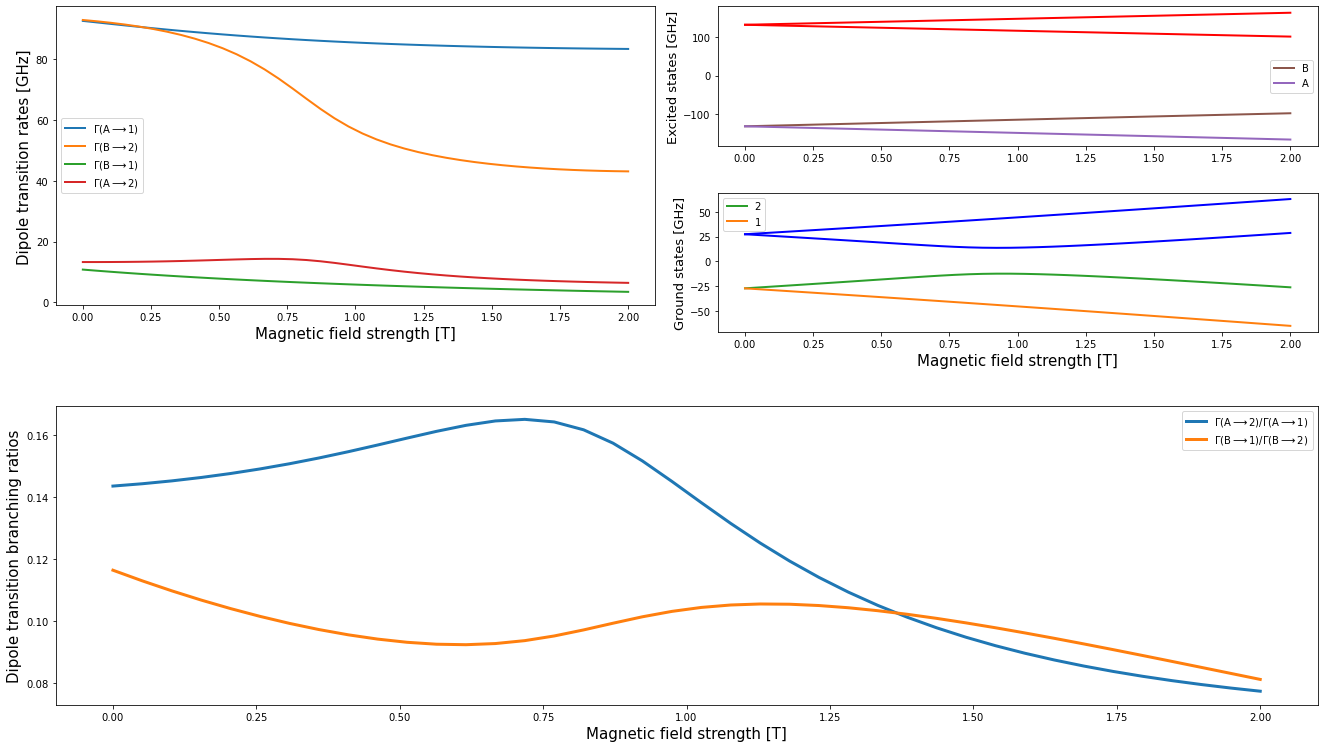

In [6]:
B_sweep = np.zeros([3,40])
B_sweep[0,:] = np.linspace(0.0001,2/np.sqrt(3),40)
B_sweep[1,:] = np.linspace(0.0001,2/np.sqrt(3),40)
B_sweep[2,:] = np.linspace(0.0001,2/np.sqrt(3),40)
 
output = siv.dipole_transitions(B_sweep)

<ipython-input-3-805d6c13f00c>:367: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


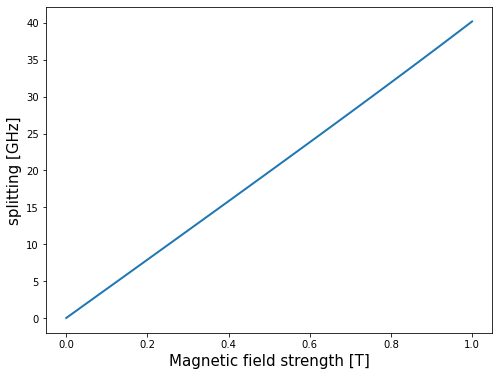

In [7]:
siv.update_val(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
siv.qubit_splitting_Bmag()

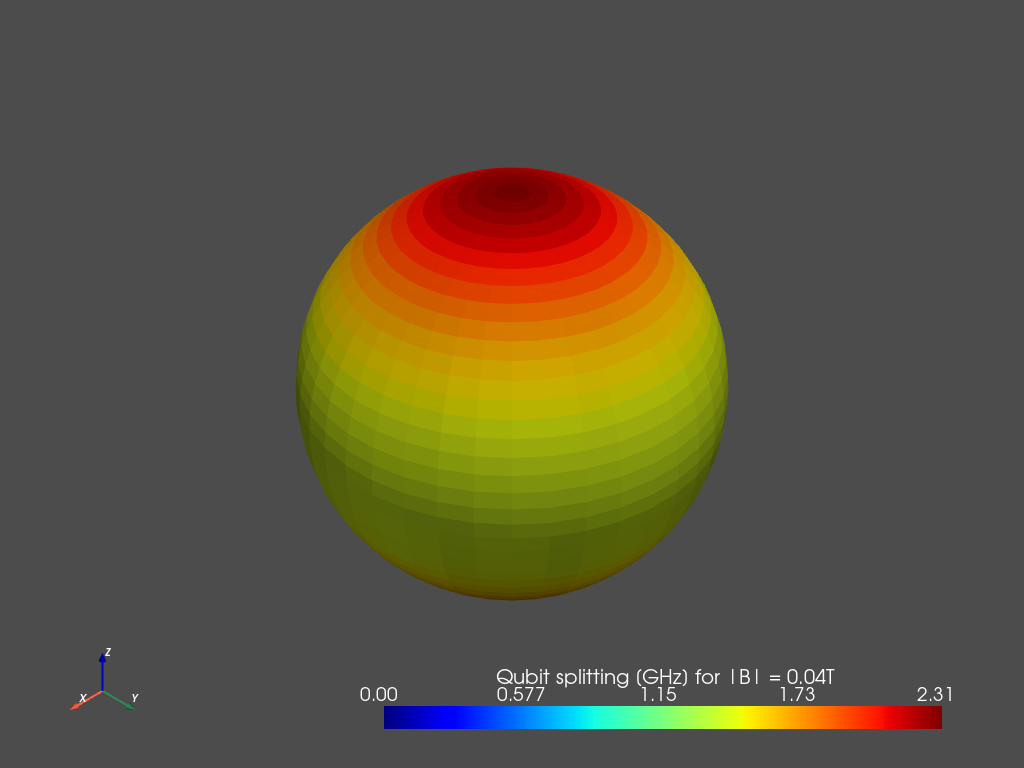

In [8]:
siv.update_val(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
siv.qubit_splitting_sphere(B_mag=0.04)

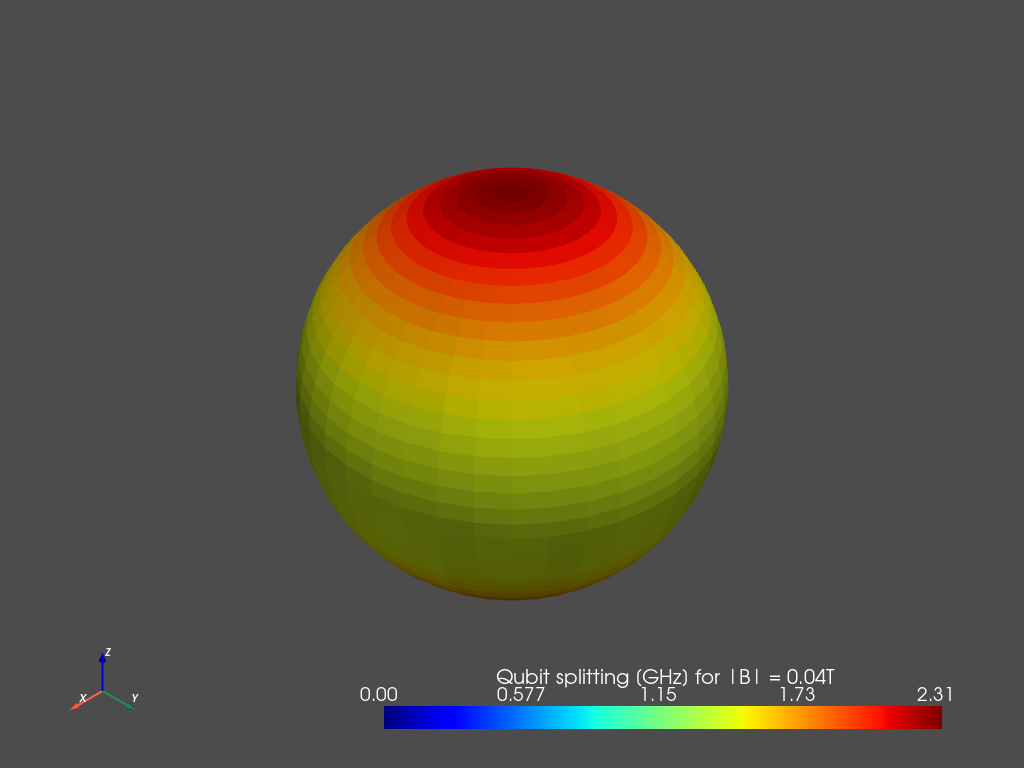

52.21736407279968


In [11]:
siv.update_val(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
siv.qubit_splitting_sphere(B_mag=0.04)

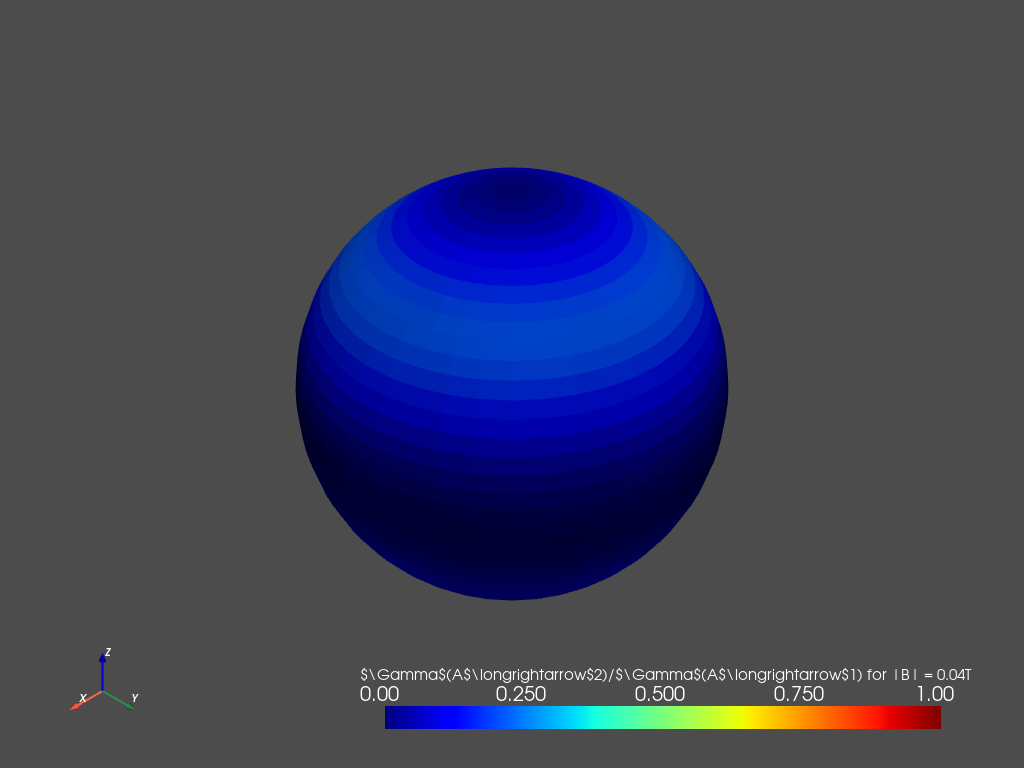

57.47527289390564


In [18]:
siv.update_val(alpha_e=450, beta_e=450, alpha_g=0, beta_g=125)
siv.A2A1_branching_ratio_sphere(B_mag=0.04)

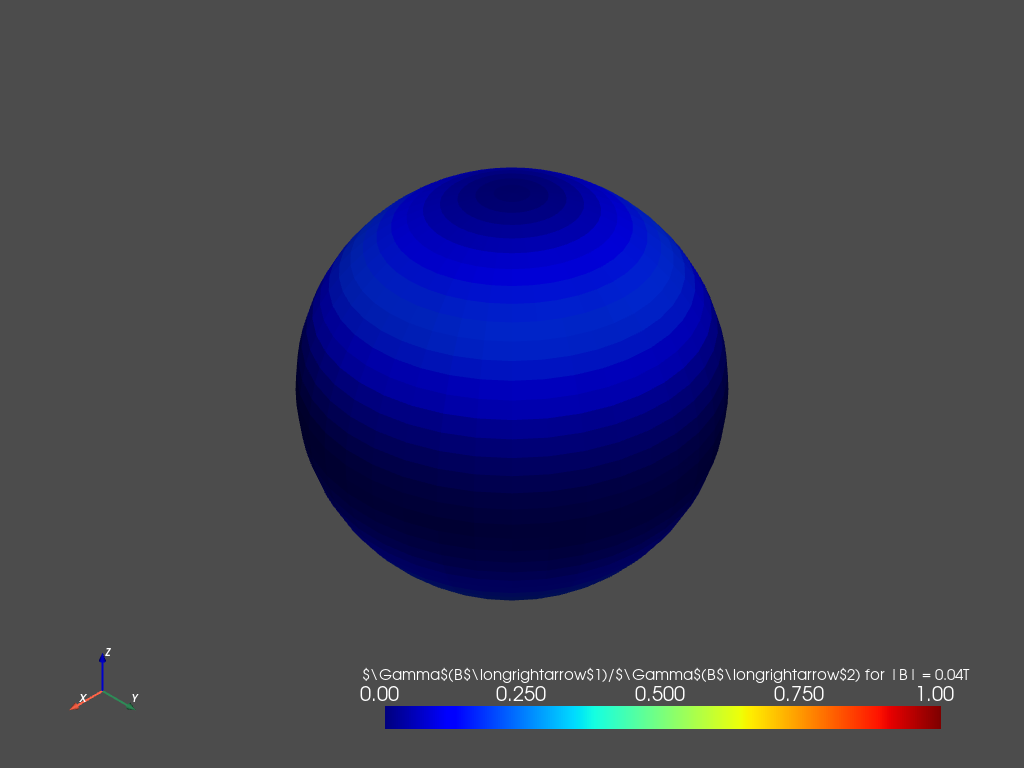

58.08317494392395


In [16]:
siv.update_val(alpha_e=450, beta_e=450, alpha_g=75, beta_g=75)
siv.B1B2_branching_ratio_sphere(B_mag=0.04)

In [259]:
siv.update_val(B=[0,0,0], alpha_e=0, beta_e=20, alpha_g=0, beta_g=0)

siv.He

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 20.  +0.j    0.  +0.j   40.+128.5j   0.  +0.j ]
 [  0.  +0.j   20.  +0.j    0.  +0.j   40.-128.5j]
 [ 40.-128.5j   0.  +0.j  -20.  +0.j    0.  +0.j ]
 [  0.  +0.j   40.+128.5j   0.  +0.j  -20.  +0.j ]]

In [260]:
siv.Hg

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 11. +0.j    0. +0.j   11.+22.5j   0. +0.j ]
 [  0. +0.j   11. +0.j    0. +0.j   11.-22.5j]
 [ 11.-22.5j   0. +0.j  -11. +0.j    0. +0.j ]
 [  0. +0.j   11.+22.5j   0. +0.j  -11. +0.j ]]

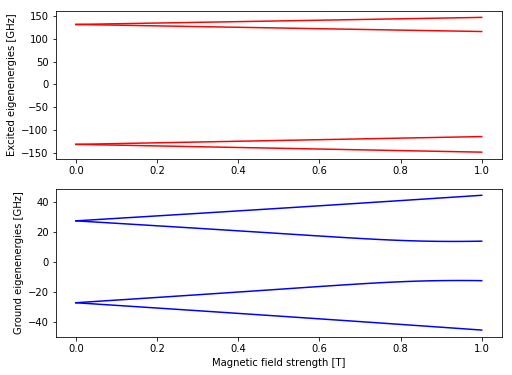

In [91]:
siv.update_val(alpha_e=0, beta_e=0, alpha_g=0, beta_g=0)

B = np.zeros([3,40])
B[0,:] = np.linspace(0,1/np.sqrt(3),40)
B[1,:] = np.linspace(0,1/np.sqrt(3),40)
B[2,:] = np.linspace(0,1/np.sqrt(3),40)

output = siv.sweep_B_field_eigenenergies(B)

/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:257: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


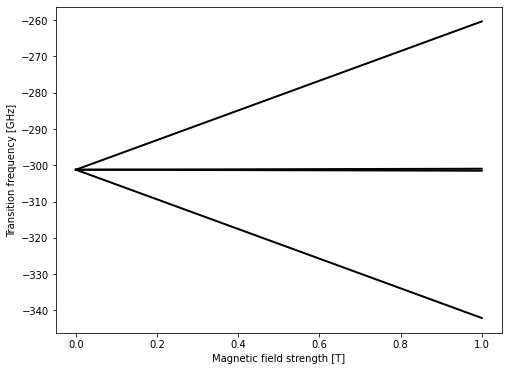

In [34]:
siv.update_val(alpha_g=50, beta_g=75, alpha_e=300, beta_e=200)

B = np.zeros([3,40])
B[0,:] = np.linspace(0,1/np.sqrt(3),40)
B[1,:] = np.linspace(0,1/np.sqrt(3),40)
B[2,:] = np.linspace(0,1/np.sqrt(3),40)

realdeal = siv.sweep_B_field_transitions(B, frozen=True)

In [119]:
siv.update_val(alpha_g=0, beta_g=0, alpha_e=0, beta_e=0)

B = np.zeros([3,15])
B[0,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[1,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[2,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[0,5:10] = np.linspace(0,0,5)
B[1,5:10] = np.linspace(0,0,5)
B[2,5:10] = np.linspace(0.1,0.9,5)
B[0,10:15] = np.linspace(0.1,1,5)/np.sqrt(2)
B[1,10:15] = np.linspace(0.1,1,5)/np.sqrt(2)
B[2,10:15] = np.linspace(0,0,5)

meas_freq = siv.sweep_B_field_transitions(B, frozen=True, plot=False)
meas_diprates = siv.dipole_transitions(B, E=[1,1,1], plot=False)

meas_br = np.zeros([2,15])
meas_br[0,:] = meas_diprates[3]/meas_diprates[0]
meas_br[1,:] = meas_diprates[2]/meas_diprates[1]

In [128]:
meas_freq.sort(axis=0)
strain_found = siv.find_strain(B_tr=B, measured_transitions=meas_freq, B_br=B, measured_branching_ratios=meas_br)
print(strain_found)

optimization succesfull: strain found
error: 2.1266736259677916e-12
[-1.965999773572442e-05, 1.9806979705346705e-05, 2.069885389619765e-05, -2.112359676920484e-05]


In [169]:
strain_found

[-115.68743481209354,
 -23.551531157206455,
 212.46269921657802,
 186.78755596579845]

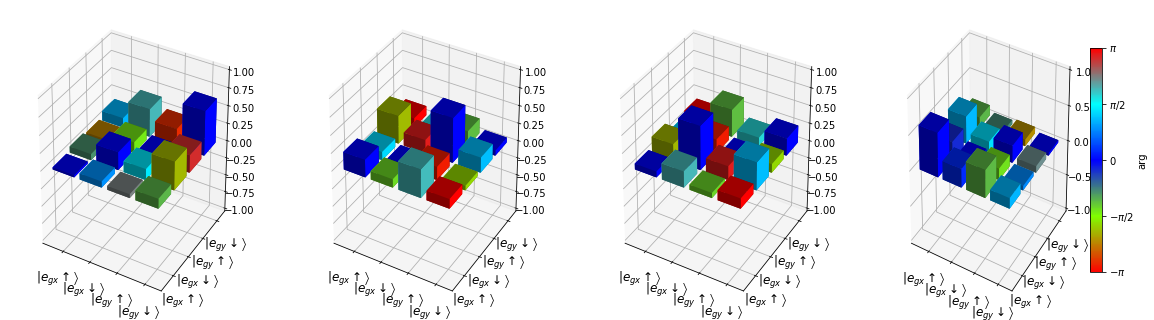

In [56]:
siv.update_val(B=[0.1,0.1,0.1])
siv.show_eigenstates(mode='ground', visualization='dm')

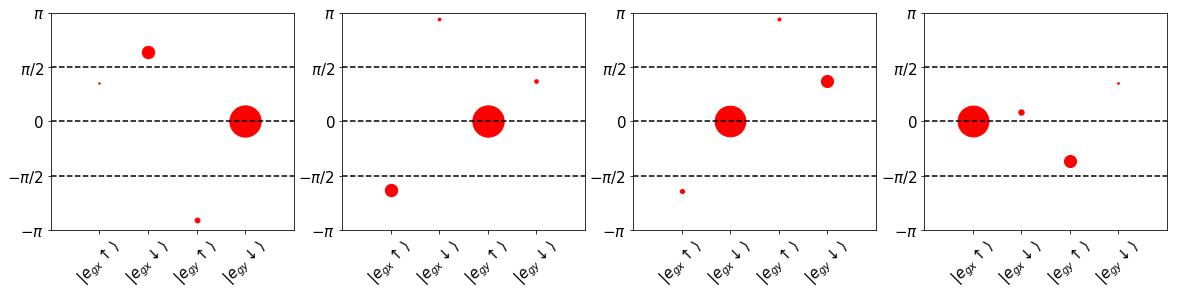

In [57]:
siv.show_eigenstates(mode='ground', visualization='circles')

/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/PjStas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


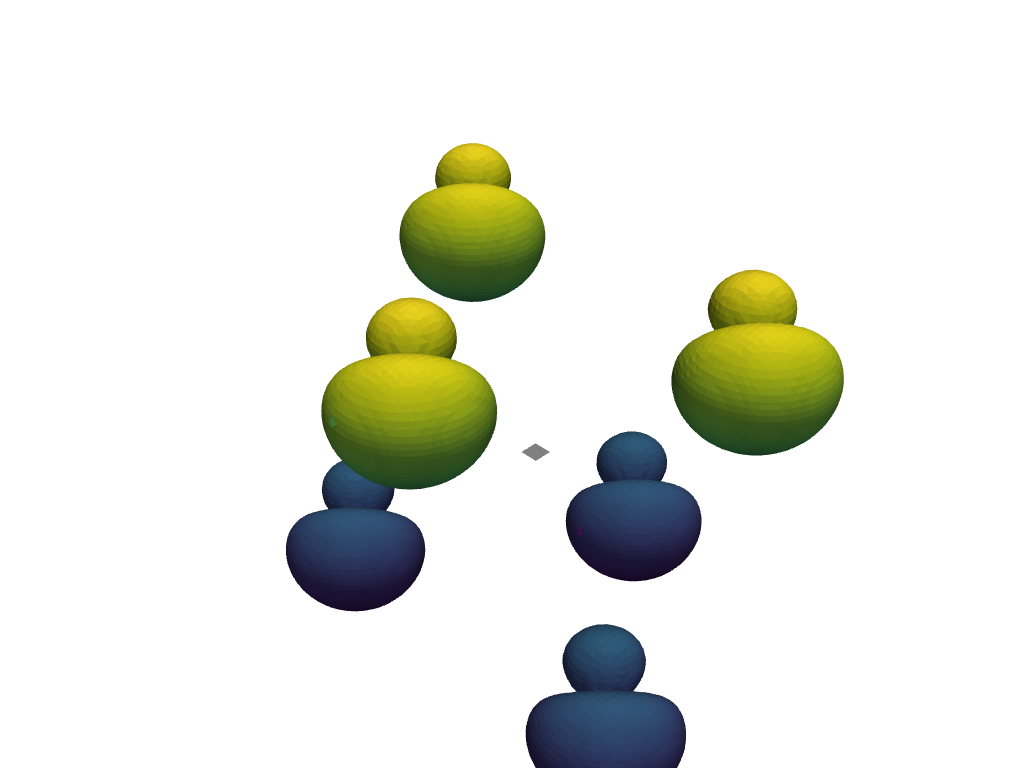

[(81.0460114647564, 77.7227994421084, 86.65716606337486),
 (4.733052077900109, 1.4098400552521113, 10.344206676518567),
 (0.0, 0.0, 1.0)]

In [48]:
from numpy import cos, pi, mgrid
import pyvista as pv

#%% Data
x, y, z = pi*mgrid[-10:10:101j, -10:10:101j, -10:10:101j]
x1 = 5*pi*np.array([1, 0, 1])
x2 = 5*pi*np.array([1, 2/np.sqrt(3), -1/np.sqrt(3)])
x3 = 5*pi*np.array([1, -2/np.sqrt(3), -1/np.sqrt(3)])
x4 = 5*pi*np.array([-1, 0, -1])
x5 = 5*pi*np.array([-1, 2/np.sqrt(3), 1/np.sqrt(3)])
x6 = 5*pi*np.array([-1, -2/np.sqrt(3), 1/np.sqrt(3)])
vol = (np.abs(sp3(x-x1[0],y-x1[1],z-x1[2]) \
              + sp3(x-x2[0],y-x2[1],z-x2[2]) \
              + sp3(x-x3[0],y-x3[1],z-x3[2]) \
              + sp3(x-x4[0],y-x4[1],z-x4[2]) \
              + sp3(x-x5[0],y-x5[1],z-x5[2]) \
              + sp3(x-x6[0],y-x6[1],z-x6[2])))**2
grid = pv.StructuredGrid(x, y, z)
grid["vol"] = vol.flatten()
contours = grid.contour([1e-4])

#%% Visualization
pv.set_plot_theme("document")
p = pv.Plotter()
p.add_floor('-z')
p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
p.show()

In [47]:
import math

def s(x,y,z):
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    return (2-r)*np.exp(-r/2)/4/np.sqrt(2*np.pi)

def pz(x,y,z):
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    
    return r*np.exp(-r/2)*np.cos(theta)/4/np.sqrt(2*np.pi)
    
def px(x,y,z):
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y/x) + ((np.abs(np.sign(y))==0) + np.sign(y))*(1-np.sign(x))*(np.abs(np.sign(x))==1)*np.pi/2
    
    return r*np.exp(-r/2)*np.sin(theta)*np.cos(phi)/4/np.sqrt(2*np.pi)
    
def py(x,y,z):
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y/x) + ((np.abs(np.sign(y))==0) + np.sign(y))*(1-np.sign(x))*(np.abs(np.sign(x))==1)*np.pi/2
    
    return r*np.exp(-r/2)*np.sin(theta)*np.sin(phi)/4/np.sqrt(2*np.pi)
    
def sp3(x,y,z):
    return (s(x,y,z) - pz(x,y,z) + px(x,y,z) - py(x,y,z))/2

In [149]:
orientation = [1,1,1]
B = np.zeros([3,40])
B[0,:] = np.linspace(0,1,40) * orientation[0] / np.linalg.norm(orientation)
B[1,:] = np.linspace(0,1,40) * orientation[1] / np.linalg.norm(orientation)
B[2,:] = np.linspace(0,1,40) * orientation[2] / np.linalg.norm(orientation)

In [63]:
error = np.array([0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5])

siv.update_val(alpha_g=50, beta_g=30, alpha_e=200, beta_e=200)

B = np.zeros([3,15])
B[0,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[1,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[2,:5] = np.linspace(0.1,1,5)/np.sqrt(3)
B[0,5:10] = np.linspace(0,0,5)
B[1,5:10] = np.linspace(0,0,5)
B[2,5:10] = np.linspace(0.1,1,5)
B[0,10:15] = np.linspace(0.1,1,5)/np.sqrt(2)
B[1,10:15] = np.linspace(0.1,1,5)/np.sqrt(2)
B[2,10:15] = np.linspace(0,0,5)

meas_freq = siv.sweep_B_field_transitions(B, frozen=True, plot=False)
meas_freq.sort(axis=0)

meas_diprates = siv.dipole_transitions(B, E=[1,1,1], plot=False)

meas_br = np.zeros([2,15])
meas_br[0,:] = meas_diprates[3]/(meas_diprates[0]+1e-12)
meas_br[1,:] = meas_diprates[2]/(meas_diprates[1]+1e-12)
    
strain_found = np.zeros([len(error), 4])
for ii in range(len(error)):
    
    MF = np.zeros([4, len(B[0,:])])
    MB = np.zeros([2, len(B[0,:])])
    
    for jj in range(len(B[0,:])):
        for kk in range(4):
            MF[kk,jj] = meas_freq[kk,jj] + np.random.normal(0, abs(error[ii]*meas_freq[kk,jj]))
            
        MB[0,jj] = abs(meas_br[0,jj] + np.random.normal(0, error[ii]))
        MB[1,jj] = abs(meas_br[1,jj] + np.random.normal(0, error[ii]))
        
    MF.sort(axis=0)
    strain_found[ii,:] = siv.find_strain(B_tr=B, measured_transitions=MF, B_br=B, measured_branching_ratios=MB)
    print('calculated for error of {} percent'.format(error[ii]*100))
    

optimization succesfull: strain found
error: 0.004008930330131971
calculated for error of 0.0 percent
optimization succesfull: strain found
error: 315.90695561964264
calculated for error of 1.0 percent
optimization succesfull: strain found
error: 1544.622350666854
calculated for error of 2.0 percent
optimization succesfull: strain found
error: 3084.174663757873
calculated for error of 3.0 percent
optimization succesfull: strain found
error: 8552.160091745374
calculated for error of 5.0 percent
optimization succesfull: strain found
error: 15366.631448713542
calculated for error of 7.000000000000001 percent
optimization succesfull: strain found
error: 35236.07212670119
calculated for error of 10.0 percent
optimization succesfull: strain found
error: 34163.11537074953
calculated for error of 15.0 percent
optimization succesfull: strain found
error: 127516.50870321156
calculated for error of 20.0 percent
optimization succesfull: strain found
error: 225381.9114343818
calculated for error of

In [39]:
error_in_percent = abs(strain_found - np.array([5, 8, 20, 50]))/np.array([5, 8, 20, 50])

Text(0.5, 0.98, '$\\alpha_g=5GHz, \\beta_g=8GHz, \\alpha_e=20GHz, \\beta_e=50GHz$')

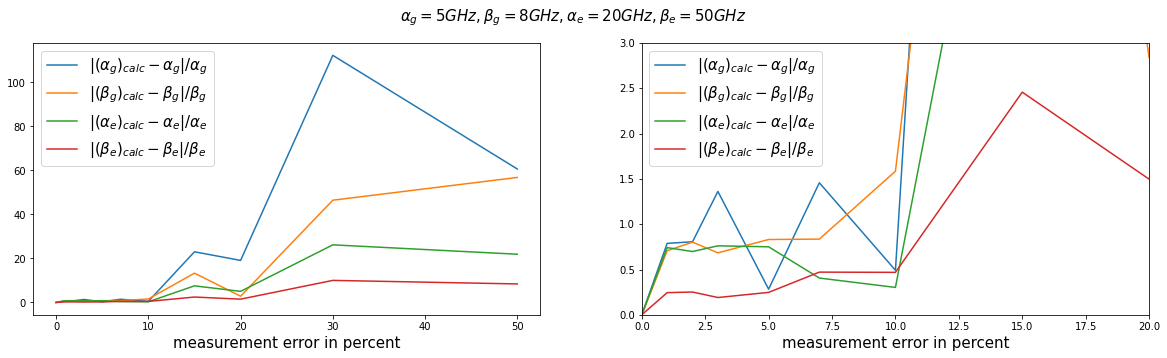

In [62]:
error = np.array([0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5])

fig, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0].plot(error*100, error_in_percent[:,0], label='$|(\\alpha_g)_{calc}-\\alpha_g|/\\alpha_g$')
axes[0].plot(error*100, error_in_percent[:,1], label='$|(\\beta_g)_{calc}-\\beta_g|/\\beta_g$')
axes[0].plot(error*100, error_in_percent[:,2], label='$|(\\alpha_e)_{calc}-\\alpha_e|/\\alpha_e$')
axes[0].plot(error*100, error_in_percent[:,3], label='$|(\\beta_e)_{calc}-\\beta_e|/\\beta_e$')
axes[0].legend(fontsize=15)
axes[0].set_xlabel('measurement error in percent', fontsize=15)
axes[1].plot(error*100, error_in_percent[:,0], label='$|(\\alpha_g)_{calc}-\\alpha_g|/\\alpha_g$')
axes[1].plot(error*100, error_in_percent[:,1], label='$|(\\beta_g)_{calc}-\\beta_g|/\\beta_g$')
axes[1].plot(error*100, error_in_percent[:,2], label='$|(\\alpha_e)_{calc}-\\alpha_e|/\\alpha_e$')
axes[1].plot(error*100, error_in_percent[:,3], label='$|(\\beta_e)_{calc}-\\beta_e|/\\beta_e$')
axes[1].legend(fontsize=15)
axes[1].set_xlabel('measurement error in percent', fontsize=15)
axes[1].set_ylim([0, 3])
axes[1].set_xlim([0, 20])

fig.suptitle('$\\alpha_g=5GHz, \\beta_g=8GHz, \\alpha_e=20GHz, \\beta_e=50GHz$', fontsize=15)

In [64]:
error_in_percent = abs(strain_found - np.array([50, 30, 200, 200]))/np.array([50, 30, 200, 200])

Text(0.5, 0.98, '$\\alpha_g=50GHz, \\beta_g=30GHz, \\alpha_e=200GHz, \\beta_e=200GHz$')

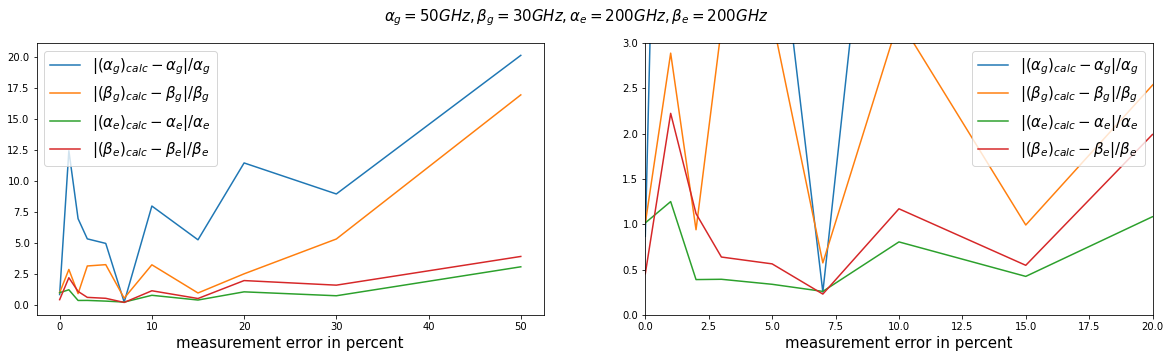

In [65]:
error = np.array([0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5])

fig, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0].plot(error*100, error_in_percent[:,0], label='$|(\\alpha_g)_{calc}-\\alpha_g|/\\alpha_g$')
axes[0].plot(error*100, error_in_percent[:,1], label='$|(\\beta_g)_{calc}-\\beta_g|/\\beta_g$')
axes[0].plot(error*100, error_in_percent[:,2], label='$|(\\alpha_e)_{calc}-\\alpha_e|/\\alpha_e$')
axes[0].plot(error*100, error_in_percent[:,3], label='$|(\\beta_e)_{calc}-\\beta_e|/\\beta_e$')
axes[0].legend(fontsize=15)
axes[0].set_xlabel('measurement error in percent', fontsize=15)
axes[1].plot(error*100, error_in_percent[:,0], label='$|(\\alpha_g)_{calc}-\\alpha_g|/\\alpha_g$')
axes[1].plot(error*100, error_in_percent[:,1], label='$|(\\beta_g)_{calc}-\\beta_g|/\\beta_g$')
axes[1].plot(error*100, error_in_percent[:,2], label='$|(\\alpha_e)_{calc}-\\alpha_e|/\\alpha_e$')
axes[1].plot(error*100, error_in_percent[:,3], label='$|(\\beta_e)_{calc}-\\beta_e|/\\beta_e$')
axes[1].legend(fontsize=15)
axes[1].set_xlabel('measurement error in percent', fontsize=15)
axes[1].set_ylim([0, 3])
axes[1].set_xlim([0, 20])

fig.suptitle('$\\alpha_g=50GHz, \\beta_g=30GHz, \\alpha_e=200GHz, \\beta_e=200GHz$', fontsize=15)